In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.regularizers import L1L2
#import project modules
from modules import *


In [ ]:
def rand_arr(a, b, *args): 
    np.random.seed(0)
    return np.random.rand(*args) * (b - a) + a

In [ ]:
class LstmParam:
    def __init__(self, ct_dim, x_dim):
        """
        
        initialize all weights and biases 
        ct_dim - the dimension of current cell state (Ct) matrix
        x_dim - the dimension of Tth input
        
        Weight and bias matrices are initialized with random values instead of zeroes to add noise. 
        Their derivatives will thus be zero.
        
        Terminology:
        
        Prefixes
        w - a weight matrix
        b - a bias matrix
        d - a derivative matrix
        
        Suffixes
        c - cell state gate. Represents data held in current cell. 
            It is the c't (c bar t) matrix
        i - input gate
        f - forget gate
        o - output gate        
        
        """
        self.ct_dim = ct_dim  
        self.x_dim = x_dim 
        combined_dim = x_dim + ct_dim
        
        # Initialize weights
        self.wc = rand_arr(-0.1, 0.1, ct_dim, combined_dim)
        self.wi = rand_arr(-0.1, 0.1, ct_dim, combined_dim) 
        self.wf = rand_arr(-0.1, 0.1, ct_dim, combined_dim)
        self.wo = rand_arr(-0.1, 0.1, ct_dim, combined_dim)
        
        #Initialize biases 
        self.bc = rand_arr(-0.1, 0.1, ct_dim) 
        self.bi = rand_arr(-0.1, 0.1, ct_dim) 
        self.bf = rand_arr(-0.1, 0.1, ct_dim) 
        self.bo = rand_arr(-0.1, 0.1, ct_dim) 
        
        # Initialize derivatives
        self.dwc = np.zeros((ct_dim, combined_dim)) 
        self.dwi = np.zeros((ct_dim, combined_dim)) 
        self.dwf = np.zeros((ct_dim, combined_dim)) 
        self.dwo = np.zeros((ct_dim, combined_dim)) 
        self.dbc = np.zeros(ct_dim) 
        self.dbi = np.zeros(ct_dim) 
        self.dbf = np.zeros(ct_dim) 
        self.dbo = np.zeros(ct_dim)
        
    def apply_derivatives(self, alpha = 1):
        """
        Update parameters in each iteration to reach optimal value 
        alpha is the learning rate.
        """
        self.wc -= alpha * self.dwc
        self.wi -= alpha * self.dwi
        self.wf -= alpha * self.dwf
        self.wo -= alpha * self.dwo
        self.bc -= alpha * self.dbc
        self.bi -= alpha * self.dbi
        self.bf -= alpha * self.dbf
        self.bo -= alpha * self.dbo
        
        # reset all derivatives to zero
        self.dwc = np.zeros_like(self.wc)
        self.dwi = np.zeros_like(self.wi) 
        self.dwf = np.zeros_like(self.wf) 
        self.dwo = np.zeros_like(self.wo) 
        self.dbc = np.zeros_like(self.bc)
        self.dbi = np.zeros_like(self.bi) 
        self.dbf = np.zeros_like(self.bf) 
        self.dbo = np.zeros_like(self.bo) 

In [ ]:
class LstmCellState:
    def __init__(self, ct_dim, x_dim):
        """
        Initialize all gate matrices. 
        All gate matrices have the same dimension as ct matrix
        c - current hidden cell state. The gate corresponding to this determines how much 
            data of previous cell should be read in current cell.
        i - input gate. Determines how much data should be read into the cell from current input.
        f - forget gate. Determines how much data should be forgotten, i.e discarded
        o - output gate. How much data to output from current cell to next cell
        s - The present state of gate. 
            Equation to calculate present state : forget_gate*previous_state(s<t-1>) + c_gate*input_gate
        h - output state of the cell. It is the prediction value of Tth output in series.
        dh - derivative of h
        ds - derivative of s
        """
        self.c = np.zeros(ct_dim)
        self.i = np.zeros(ct_dim)
        self.f = np.zeros(ct_dim)
        self.o = np.zeros(ct_dim)
        self.s = np.zeros(ct_dim)
        self.h = np.zeros(ct_dim)
        self.dh = np.zeros_like(self.h)
        self.ds = np.zeros_like(self.s)

In [ ]:
class LstmLayer:
    def __init__(self, lstm_param, lstm_cell_state):
        self.state = lstm_cell_state
        self.param = lstm_param
        #xh is the concatenation ofprevious layer's output with current input.
        self.xh = None

    def calculate_gates(self, x, s_prev = None, h_prev = None):
        """
        if this is the first lstm layer in the network then 
        s_prev and h_prev will be initialized to zero as cell state 
        and output states are not present.
        
        s_prev = cell state of previous layer's cells.
        h_prev = output state from previous layer
        
        """
        if s_prev is None: 
            s_prev = np.zeros_like(self.state.s)
        if h_prev is None: 
            h_prev = np.zeros_like(self.state.h)
        
        # save previous states for use in backprop
        self.s_prev = s_prev
        self.h_prev = h_prev

        # concatenate x(T) and h(T-1)
        xh = np.hstack((x,  h_prev))
        #Calculate gate values
        self.state.c = tanh(np.dot(self.param.wc, xh) + self.param.bc)
        self.state.i = sigmoid(np.dot(self.param.wi, xh) + self.param.bi)
        self.state.f = sigmoid(np.dot(self.param.wf, xh) + self.param.bf)
        self.state.o = sigmoid(np.dot(self.param.wo, xh) + self.param.bo)
        self.state.s = self.state.c * self.state.i + s_prev * self.state.f
        self.state.h = self.state.s * self.state.o
        self.xh = xh
    
    def calculate_derivatives(self, dh, ds):
        ds = self.state.o * dh + ds
        do = self.state.s * dh
        di = self.state.c * ds
        dc = self.state.i * ds
        df = self.s_prev * ds

        # calculate derivatives w.r.t. gate inside sigma / tanh function
        di_input = dsigmoid(self.state.i) * di 
        df_input = dsigmoid(self.state.f) * df 
        do_input = dsigmoid(self.state.o) * do 
        dc_input = dtanh(self.state.c) * dc

        # derivatives w.r.t. inputs
        self.param.dwc += np.outer(dc_input, self.xh)
        self.param.dwi += np.outer(di_input, self.xh)
        self.param.dwf += np.outer(df_input, self.xh)
        self.param.dwo += np.outer(do_input, self.xh)
        self.param.dbc += dc_input       
        self.param.dbi += di_input
        self.param.dbf += df_input       
        self.param.dbo += do_input
        
        # calculate derivative for xh
        dxh = np.zeros_like(self.xh)
        dxh += np.dot(self.param.wc.T, dc_input)
        dxh += np.dot(self.param.wi.T, di_input)
        dxh += np.dot(self.param.wf.T, df_input)
        dxh += np.dot(self.param.wo.T, do_input)
        
        # save derivatives
        self.state.ds = ds * self.state.f
        self.state.dh = dxh[self.param.x_dim:]

In [ ]:
class LstmNetwork():
    def __init__(self, lstm_param):
        """
        x_list - the sequence that'll be iput to lstm
        lstm_layer_list - the ouput from layer that will be input to next layer
        """
        self.lstm_param = lstm_param
        self.lstm_layer_list = []
        self.x_list = []

    def get_loss(self, y_list, loss_layer):
        """
        Updates derivatives w.r.t corresponding loss layer. 
        To update parameters, we will call self.lstm_param.apply_derivatives()
        """
        index = len(self.x_list) - 1
        # Calculate loss for the last layer 
        loss = loss_layer.loss(self.lstm_layer_list[index].state.h, y_list[index])
        diff_h = loss_layer.derivative(self.lstm_layer_list[index].state.h, y_list[index])
        # For the last layer of the network, diff_s will be
        diff_s = np.zeros(self.lstm_param.ct_dim)
        self.lstm_layer_list[index].calculate_derivatives(diff_h, diff_s)
        index -= 1

        while index >= 0:
            loss += loss_layer.loss(self.lstm_layer_list[index].state.h, y_list[index])
            diff_h = loss_layer.derivative(self.lstm_layer_list[index].state.h, y_list[index])
            diff_h += self.lstm_layer_list[index + 1].state.dh
            diff_s = self.lstm_layer_list[index + 1].state.ds
            self.lstm_layer_list[index].calculate_derivatives(diff_h, diff_s)
            index -= 1 

        return loss

    def clear_x_list(self):
        self.x_list = []

    def add_x_list(self, x):
        self.x_list.append(x)
        if len(self.x_list) > len(self.lstm_layer_list):
            lstm_state = LstmCellState(self.lstm_param.ct_dim, self.lstm_param.x_dim)
            self.lstm_layer_list.append(LstmLayer(self.lstm_param, lstm_state))

        # get index of most recent x input
        index = len(self.x_list) - 1
        if index == 0:
            self.lstm_layer_list[index].calculate_gates(x)
        else:
            s_prev = self.lstm_layer_list[index - 1].state.s
            h_prev = self.lstm_layer_list[index - 1].state.h
            self.lstm_layer_list[index].calculate_gates(x, s_prev, h_prev)

In [2]:
def normalize_dataset(stock_market_dataset):
    normalizer = preprocessing.MinMaxScaler((0,1))
    smd_exclude_strings = stock_market_dataset.select_dtypes(include = [np.number])
    normalized = normalizer.fit_transform(smd_exclude_strings)
    return [normalized, normalizer]

def denormalize_data(df, normalizer, time_step, predictions, close_value_col_index):
    df_copy = df.copy(deep = True)
    rows_to_drop = [i for i in range(0,time_step)]
    df_copy.drop(rows_to_drop,inplace = True)     
    #deleting first #time_step rows of normalized_df. Because output prediction for the first 30 days (first time slice) doesn't exist.

    #converting prediction array to dataframe for replacing actual row with prediction row
    predicted_normalised_values_df = pd.DataFrame(predictions) 

    #replacing
    df_copy[close_value_col_index][0:len(predictions)] = predicted_normalised_values_df[0].values
    
    temp = normalizer.inverse_transform(df_copy)
    df_copy = pd.DataFrame(temp)
    return df_copy[close_value_col_index][0:len(predictions)]

def make_train_test_val_sets(dataarray, num_features, close_value_col_index, time_step, train_per, val_per, test_per):
    n = dataarray.shape[0] 

    #slices of data into time_steps 
    X_slice=[]
    y_slice=[]
    #normalized df dim 3125, 13
    # i = 30 - 3125

    for i in range(time_step, n):
        X_slice.append(dataarray[ i-time_step:i ,  close_value_col_index] )      #1 example having data from 30 days dim 30x13
        y_slice.append(dataarray[i,close_value_col_index])                  #close value data of the 31st day 

    #splitting percentage

    #splitting slices for test,val,train and converting into np array
    X_train=np.array( X_slice[ 0:int(n*train_per) ])
    y_train=np.array( y_slice[ 0:int(n*train_per) ])

    X_val=np.array( X_slice[ int(n*train_per):int(n*(train_per+val_per)) ])
    y_val=np.array( y_slice[ int(n*train_per):int(n*(train_per+val_per)) ])

    X_test=np.array( X_slice[ int(n*(train_per+val_per)):int(n*(train_per+val_per+test_per))])
    y_test=np.array( y_slice[ int(n*(train_per+val_per)):int(n*(train_per+val_per+test_per))])
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))    
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], num_features))    
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))    
    #print(np.array(X_train).shape)
    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))    
    #dimension of X_train 3095, 30, 13
    #dimension of y_train  
    #print(np.array(X_train).shape)
    return [X_train, y_train, X_val, y_val, X_test, y_test]

In [3]:
tickerSymbol = 'MSFT'
tickerData = yf.Ticker(tickerSymbol)
stock_market_dataset = tickerData.history(period='1d', start='2010-1-1', end='2020-1-25')
stock_market_dataset
#data_set_file = 'Google.csv'
#stock_market_dataset = pd.read_csv(data_set_file)
#stock_market_dataset.shape
#stock_market_dataset

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-12-31,24.073285,24.081056,23.684755,23.684755,31929700,0.0,0
2010-01-04,23.793539,24.166527,23.770227,24.049969,38409100,0.0,0
2010-01-05,23.972268,24.166532,23.809084,24.057743,49749600,0.0,0
2010-01-06,23.995573,24.150985,23.715832,23.910097,58182400,0.0,0
2010-01-07,23.801302,23.855697,23.459397,23.661432,50559700,0.0,0
...,...,...,...,...,...,...,...
2020-01-17,165.284340,165.333705,163.319719,164.968430,34371700,0.0,0
2020-01-21,164.553765,166.044512,164.306954,164.376068,29517200,0.0,0
2020-01-22,165.264584,165.353448,163.566524,163.586273,24138800,0.0,0


In [4]:
###split data set into train, cross validation and test set

num_features = 6 
close_value_col_index = 4
select_cols = stock_market_dataset[['Close']]
new_df = select_cols.copy()

###normalize data
normalized_array, normalizer = normalize_dataset(new_df)
#normalized_df.head()
#n = normalized_df.shape[0]

#creating training set with time steps.

time_step=30    #1 month time step
train_per = 0.015
val_per = 0.015
test_per = 0.0035
    
X_train, y_train, X_val, y_val, X_test, y_test =  make_train_test_val_sets(normalized_array, 1, 0, time_step, train_per, val_per, test_per)

print(str(X_train.shape)+ " training dataset shape")
print(str(X_val.shape)+ "  val dataset shape")
print(str(X_test.shape)+ "  test dataset shape")

(37, 30, 1) training dataset shape
(38, 30, 1)  val dataset shape
(9, 30, 1)  test dataset shape


In [7]:
class LossLayer:
    """
    Computes square loss with first element of hidden layer array.
    """
    @classmethod
    def loss(self, pred, label):
        return (pred[0] - label) ** 2

    @classmethod
    def derivative(self, pred, label):
        diff = np.zeros_like(pred)
        diff[0] = 2 * (pred[0] - label)
        return diff
    
    def percentage_error(pred, label):
        return (100/len(pred))*np.sum(np.absolute(np.array(label)-np.array(pred))/np.array(label))


# learns to repeat simple sequence from random inputs
np.random.seed(0)

# parameters for input data dimension and lstm cell count
mem_cell_ct = 100
x_dim = time_step
lstm_param = LstmParam(mem_cell_ct, x_dim)
lstm_net = LstmNetwork(lstm_param)
y_list = y_train.tolist()
input_val_arr = X_train.tolist()
for cur_iter in range(1200):
    if ((cur_iter+1)%100 == 0):
        print("iter", "%2s" % str(cur_iter+1), end=": ")
    for ind in range(len(y_list)):
        lstm_net.add_x_list(input_val_arr[ind])

    #print("y_pred = [" +
    #      ", ".join("[% 2.5f % 2.5f]" % (lstm_net.lstm_layer_list[ind].state.h[0], y_list[ind]) for ind in range(len(y_list))) +
    #      "]", end=", ")

    loss = lstm_net.get_loss(y_list, LossLayer)
    if ((cur_iter+1)%100 == 0):
        print("loss:", "%.3e" % loss)
    lstm_param.apply_derivatives(0.1)
    lstm_net.clear_x_list()

pred = []
for ind in range(len(y_list)):
    pred.append(lstm_net.lstm_layer_list[ind].state.h[0])

print("Accuracy: % 2.2f%%" % (100-LossLayer.percentage_error(pred, y_list)))


NameError: name 'LstmParam' is not defined

In [ ]:
#Cross Val 
y_list = y_val.tolist()
input_val_arr = X_val.tolist()
for ind in range(len(y_list)):
    lstm_net.add_x_list(input_val_arr[ind])

pred = []
for ind in range(len(y_list)):
    pred.append(lstm_net.lstm_layer_list[ind].state.h[0])

print(len(pred))
lstm_net.clear_x_list()

print("Accuracy: % 2.2f%%" % (100-LossLayer.percentage_error(pred, y_list)))


In [ ]:
#Test  
y_list = y_test.tolist()
input_val_arr = X_test.tolist()
for ind in range(len(y_list)):
    lstm_net.add_x_list(input_val_arr[ind])

pred = []
for ind in range(len(y_list)):
    pred.append(lstm_net.lstm_layer_list[ind].state.h[0])

print(len(pred))
lstm_net.clear_x_list()
print("Accuracy: % 2.2f%%" % (100-LossLayer.percentage_error(pred, y_list)))

In [ ]:
denormed = denormalize_data(pd.DataFrame(normalized_array), normalizer, time_step, pred, 0)

In [ ]:
def get_prediction(df, day_index, time_step, lstm_net, y_list):   #date should be greater than time_step
    actual = df['Close'][day_index]    
    select_cols = df[['Close']]
    new_df = select_cols.copy()
    normalized, normalizer = normalize_dataset(new_df)
    norm_actual = normalized[day_index][0]
    y_list.append(norm_actual)
    sequence = [normalized[i] for i in range(day_index-time_step,day_index)]
    lstm_net.add_x_list(np.reshape(np.array(sequence), (time_step)).tolist())
    pred = lstm_net.lstm_layer_list[len(lstm_net.lstm_layer_list)-1].state.h[0]
    normalized[day_index][0] = pred
    temp = normalizer.inverse_transform(pd.DataFrame(normalized))
    lstm_net.clear_x_list()
    #print(temp[day_index][0], actual)
    return temp[day_index][0], actual
    

get_prediction(stock_market_dataset, 50, 30, lstm_net, y_list)

In [5]:
# Prediction With keras
train_per = 0.7
val_per = 0.2
test_per = 0.1
X_train, y_train, X_val, y_val, X_test, y_test =  make_train_test_val_sets(normalized_array, 1, 0, time_step, train_per, val_per, test_per)

print(str(X_train.shape)+ " training dataset shape")
print(str(X_val.shape)+ "  val dataset shape")
print(str(X_test.shape)+ "  test dataset shape")
#Implementing LSTM
model = keras.models.Sequential()         #initializing network

#input layer
hidden_layer_units = 10
model.add(keras.layers.LSTM(hidden_layer_units,kernel_regularizer=L1L2(0.0001), return_sequences=True, input_shape=(X_train.shape[1],1)))

#LSTM layer 2
hidden_layer_units = 10
model.add(keras.layers.LSTM(hidden_layer_units,kernel_regularizer=L1L2(0.0001)))

#Output layer
output_layer_units = 1     #just need the close value
model.add(keras.layers.Dense(output_layer_units))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 70, batch_size = 10)

(1773, 30, 1) training dataset shape
(506, 30, 1)  val dataset shape
(224, 30, 1)  test dataset shape
178/178 [==============================] - 30s 121ms/step - loss: 0.0110


In [6]:
real_close_value = pd.DataFrame(normalized_array).iloc[ time_step: , close_value_col_index:close_value_col_index+1].values     #Close column normalized real value. Ideally predictions should be on test set.

print(real_close_value.shape)

predicted_close_value_train = model.predict(X_train)
predicted_close_value_val = model.predict(X_val)
predicted_close_value_test  = model.predict(X_test)   
combined_prediction = np.append(predicted_close_value_train,np.append(predicted_close_value_val,predicted_close_value_test))

print(predicted_close_value_test.shape, X_test.shape)

(2503, 0)
(224, 1) (224, 30, 1)


In [7]:
temp = normalizer.inverse_transform(pd.DataFrame(normalized_array))
real_close_value = pd.DataFrame(temp)
temp = normalizer.inverse_transform(pd.DataFrame(combined_prediction))
predicted_close_value = pd.DataFrame(temp)

rows_to_drop = [i for i in range(0,time_step)]
real_close_value.drop(rows_to_drop,inplace = True)     #deleting first 30 rows of normalized_df. Because output prediction for the first 30 days (first time slice) doesn't exist.
print(predicted_close_value.shape, real_close_value.shape)
real_close_value = np.array(real_close_value)

(2503, 1) (2503, 1)


(30,)


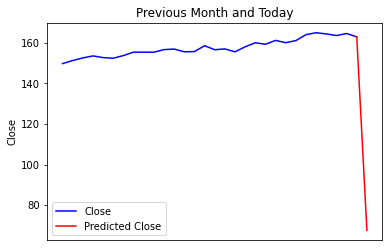

(2503, 1)


In [15]:
def get_pred(day_index, model, label, time_step, num_features, normalizer):
    if day_index>len(label):
        print("Day:",day_index,"is out of series range:",len(label))
        return
    
    sequence = np.array([label[i][0] for i in range(day_index-time_step,day_index)])
    print(sequence.shape)
    sequence = np.reshape(sequence, (1, time_step, num_features))
    pred = model.predict(sequence)
    pred = normalizer.inverse_transform(pd.DataFrame(pred))
    x_coords = [i for i in range(day_index-time_step,day_index)]
    y_coords = [label[i][0] for i in range(day_index-time_step,day_index)]
    x_on_day = [day_index-1,day_index]
    y_on_day = [label[day_index-1],pred[0][0]]
    plt.plot(x_coords, y_coords, color = 'blue', label = 'Close')
    plt.plot(x_on_day, y_on_day, color = 'red', label = 'Predicted Close')
    plt.xticks([])
    plt.title('Previous Month and Today')
    plt.ylabel('Day')
    plt.ylabel('Close')
    
    plt.legend()
    plt.show()
    
get_pred(2503, model, real_close_value, time_step, 1, normalizer)
print(real_close_value.shape)